In [1]:
import os, sys, glob
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
# from tqdm.notebook import tqdm

from tqdm import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import pickle

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    PerspectiveCameras,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
)
from PIL import Image

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from pytorch3d.io import load_obj, load_ply
from pytorch3d.renderer import RasterizationSettings, PointLights, MeshRenderer, MeshRasterizer, TexturesVertex, SoftPhongShader, SfMPerspectiveCameras, PerspectiveCameras, BlendParams, FoVPerspectiveCameras, FoVOrthographicCameras
from pytorch3d.structures import Meshes
import json
import moviepy
import moviepy.editor
import cv2
from skimage import util

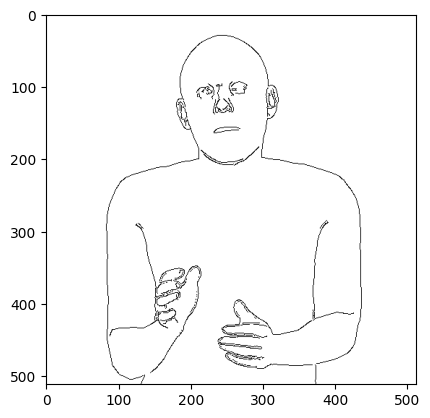

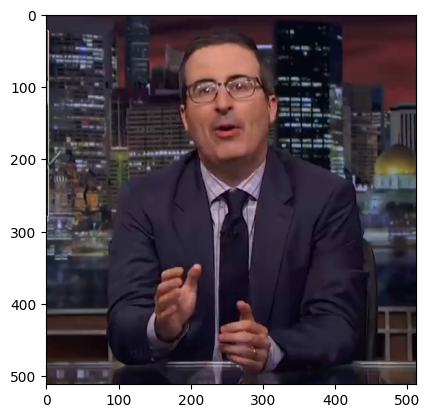

In [14]:
data = './data/john-oliver-SHOW1/JO_SHOW1/images/00001.png'
img1 = np.array(Image.open(data))
data = './data/john-oliver-SHOW1/JO_SHOW1/untexture_meshes/00000.png'
img2 = np.array(Image.open(data))
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, threshold1=30, threshold2=100)
edges = util.invert(edges)
plt.imshow(edges, cmap="gray")
plt.show()

# img = (img1 * 0.5 + edges * 0.5).clip(0, 255)
# print(img.min(), img.max())
plt.imshow(img1/255)

(512, 512)


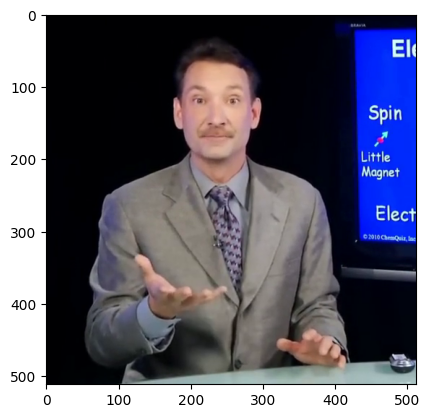

Number of objects is 3
(512, 512)


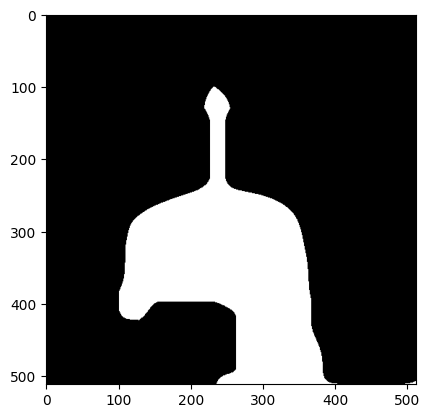

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


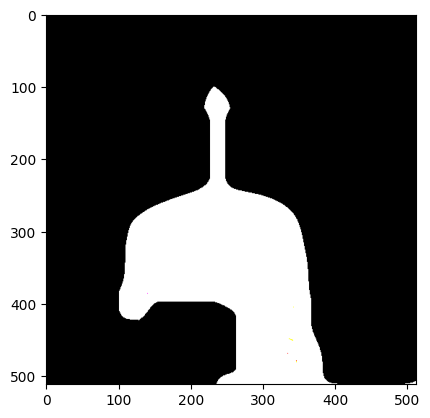

In [28]:

from PIL import Image
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

fname='./data/chemistry-SHOW1/background/00200.png'
blur_radius = 10.0
threshold = 5

img = Image.open(fname).convert('L')
img_c = Image.open(fname)
img_color = np.asarray(img_c)
img = np.asarray(img)
print(img.shape)
# (160, 240)
plt.imshow(Image.open(fname))
plt.show()

# smooth the image (to remove small objects)
imgf = ndimage.gaussian_filter(img, blur_radius)
threshold = 50

# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is {}".format(nr_objects))
# Number of objects is 4 

mask = (labeled==2)
print(mask.shape)
# mask = ndimage.gaussian_filter(img, 30)
kernel = np.ones((15,15), np.uint8)
mask = cv2.erode((mask*255).astype(np.uint8), kernel, iterations=5)

plt.imsave('/tmp/out.png', mask)
plt.imshow(mask, cmap='gray')
plt.show()

plt.imshow((mask[:,:,None]/255) * img_c)
plt.show()

In [48]:
files1 = glob.glob('./data/johnoliver_upper_2100/images/*.png')
files2 = glob.glob('./data/johnoliver_upper_2100/mesh_renders2/*.png')
files1.sort()
files2.sort()
outVid = []

for i in tqdm(range(len(files2))):
    img1 = Image.open(files1[i])
    img1 = np.array(img1)[...,:3]
    img2 = Image.open(files2[i])
    img2 = np.array(img2)
    img = np.concatenate((img1, img2), axis=1)
    outVid.append(img)
moviepy.editor.ImageSequenceClip(sequence=[(npyFrame).clip(0.0, 255.0).round().astype(np.uint8) 
                                        for npyFrame in outVid], fps=30).write_videofile('./data/johnoliver_upper_2100/video.mp4')

  0%|          | 0/2100 [00:00<?, ?it/s]

100%|██████████| 2100/2100 [00:52<00:00, 39.69it/s]


Moviepy - Building video ./data/johnoliver_upper_2100/video.mp4.
Moviepy - Writing video ./data/johnoliver_upper_2100/video.mp4



Moviepy - Done !
Moviepy - video ready ./data/johnoliver_upper_2100/video.mp4


In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
obj_filename = os.path.join('./data/johnoliver_hands_2100/meshes/00000.obj')

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

In [3]:
arr = np.load('./data/johnoliver_hands_2100/all_transl.npy',)
print(arr.shape, arr[1300])

(2100, 3) [-0.12680875 -0.74105567  5.8286767 ]


In [70]:
print(mesh.verts_packed().shape)
print(mesh.verts_list()[0].shape)


torch.Size([8465, 3])
torch.Size([8465, 3])


In [24]:
def set_pytorch3D(T):
    # print(transl[0])#[-0.19163294 -0.7803175   5.7486043 ]
    n_frame = T.shape[0]
    #transl = transl_list[0]
    #transl[:,1] *= -1
    # R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
    # T = np.array([[-0.19163294, -0.7803175, 5.7486043 ]])
    T = T
    # T = np.array([[-0.12680875, -0.74105567, 5.8286767 ]])
    # T = np.array([[-0.09465549886226654, -0.005827873945236206, 0.6586162447929382]])
    # fl = np.array([[19.53125]]).repeat(n_frame, 0) #depends on z_near and z_far
    # pp = np.array([[0.75, -0.37109375]]).repeat(n_frame, 0) #depends on bbox
    ###-----------------------------------------------------------------------------------------###
    # Shoulders with hands
    # fl = np.array([[16.129]]).repeat(n_frame, 0)
    # pp = np.array([[0.58065, -0.016129]]).repeat(n_frame, 0)
    R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
    
    # #john-oliver-SHOW
    # fl = np.array([[15.625]]).repeat(n_frame, 0)
    # pp = np.array([[0.5625, 0]]).repeat(n_frame, 0)
    
    # # chemistry-SHOW
    # fl = np.array([[16.66666667]]).repeat(n_frame, 0)
    # pp = np.array([[-0.86666667, -0.06666667]]).repeat(n_frame, 0)
    
    #conan-SHOW
    fl = np.array([[19.53125]]).repeat(n_frame, 0)
    pp = np.array([[-0.1328125, -0.25]]).repeat(n_frame, 0)

    # #seth-SHOW
    # fl = np.array([[15.625]]).repeat(n_frame, 0)
    # pp = np.array([[0.09375, 0.]]).repeat(n_frame, 0)
    
    return fl, pp, R, T

def set_pytorch3D_upper(file, cnt=None):
    f = open(file)
    data = json.load(f)
    n_frame = len(data['frames']) if cnt is None else cnt
    R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
    T = []
    for i in range(n_frame):
        T.append(np.array(data['frames'][i]['transform_matrix'])[:-1,-1])
    T = np.array(T)
    fl = np.array([[data['fl_x']]]).repeat(n_frame, 0)
    pp = np.array([[data['cx'], data['cy']]]).repeat(n_frame, 0)
    return fl, pp, R, T

In [72]:
file = './data/johnoliver_hands_2100/transforms.json'
f = open(file)
data = json.load(f)
print(len(data['frames']))
print(np.array(data['frames'][0]['transform_matrix'])[:-1,-1])
# fl, pp, R, T = set_pytorch3D_upper(file, cnt=10)
# print(fl.shape, pp.shape, R.shape, T.shape)
fl, pp, R, T = set_pytorch3D()
print(fl.shape, pp.shape, R.shape, T.shape)

2100
[-0.0946555  -0.00582787  0.65861624]
(1, 1) (1, 2) (1, 3, 3) (1, 3)


(7560, 3) [-0.01196265 -0.6456037   8.696586  ]
[19.53125] [-0.1328125 -0.25     ] [-0.01196265 -0.6456037   8.696586  ]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

[19.53125] [-0.1328125 -0.25     ] [-0.01196265 -0.6456037   8.696586  ]
(512, 512, 3)


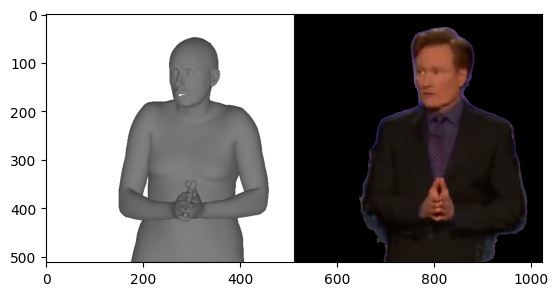

In [25]:
device = 'cuda'
idx = 'conan'
Tr = np.load(f'./data/{idx}-SHOW1/all_transl_SHOW_{idx}.npy',)
# Tr = Tr[int(Tr.shape[0]*0.8):]
print(Tr.shape, Tr[0])
fl, pp, R, T = set_pytorch3D(Tr)
print(fl[0], pp[0], T[0])

# files = glob.glob('./data/johnoliver_hands_2100/meshes/*.obj')
files = glob.glob(f'./data/mesh_rot_180/{idx}/*.obj')
# files = glob.glob('./data/jhonoliver_upper_2100/faces_hands_mesh_rot180/*.obj')
# files = glob.glob('./data/jhonoliver_upper_2100/faces_hands_mesh_rot180/*.obj')
files.sort()
meshes = []
for i in tqdm(range(0, 1)):
    verts1, faces1, _ = load_obj(files[i], device=device)
    V = verts1.shape[0]
    verts_rgb = torch.from_numpy(np.array([0.5, 0.5, 0.5])).float()[None, None, :].repeat(1,V,1)
    textures = TexturesVertex(verts_features=verts_rgb,).to(device)
    mesh = Meshes(verts=verts1[None], faces=faces1.verts_idx[None], textures=textures,).to(device)
    meshes.append(mesh)
# save_path = './checkpoints/jhon-oliver-upper-hands-vertex-texture-fitting'
# save_path = './checkpoints/jhon-oliver-upper-vertex-texture-fitting'
# save_path = './checkpoints/jhon-oliver-upper-hands-uv-texture-fitting'
# meshes = torch.load(os.path.join(save_path, 'meshes_train.pt'))
# print(len(meshes))
res = 512
sigma = 1e-4
raster_settings = RasterizationSettings(
        image_size=res,
        faces_per_pixel=1,
        # blur_radius=(np.log(1. / 1e-4 - 1.)*sigma),
        cull_backfaces=True,
        perspective_correct=True
)
lights = PointLights(
            device=device,
            location=((0.0, 0.0, 5.0),),
            ambient_color=((0.5, 0.5, 0.5),),
            diffuse_color=((0.5, 0.5, 0.5),)
        )

materials = Materials(
        specular_color=((0, 0, 0),),
        device=device,
)
print(fl[0], pp[0], T[0])
camera = PerspectiveCameras(focal_length=fl, 
                             principal_point=pp, 
                             R=R, 
                             T=T, 
                             image_size=res, 
                             device=device)

blend = BlendParams(background_color=(1.0, 1.0, 1.0))
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        materials=materials,
        blend_params=blend,
    )
)

# save_path = './data/johnoliver_hands_2100/mesh_renders2'
# os.makedirs(save_path, exist_ok=True)

# for i in tqdm(range(len(files))):
#     name = files[i].split('/')[-1].replace('.obj', '.png')
#     target_image = renderer(meshes[i], cameras=camera[i])[0,...,:3]
#     target_image = (target_image.detach().cpu().numpy() * 255.).astype(np.uint8)
#     target_image = Image.fromarray(target_image).save(os.path.join(save_path, name))
    

target_images = renderer(meshes[0], cameras=camera[0])
# print(camera[0].get_projection_transform()._matrix)

num_views = 1
target_rgb_single = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [camera]
from matplotlib import pyplot as plt
img_rgb = Image.open(f'./data/{idx}-SHOW1/matted/00001.png').resize((res, res))
img_rgb = np.array(img_rgb)[:,:,:3] / 255.
print(img_rgb.shape)
plt.imshow(np.concatenate((target_rgb_single[0].cpu().numpy(), img_rgb), axis=1))
plt.show()

torch.Size([1, 256, 256, 1]) tensor(5.2723, device='cuda:0')
torch.Size([1, 256, 256, 1]) tensor(1., device='cuda:0')


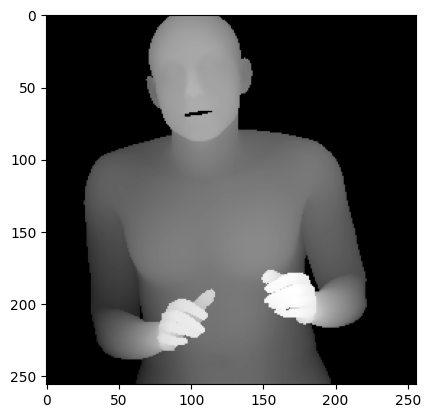

torch.Size([1, 256, 256, 3]) tensor(0.9999, device='cuda:0') tensor(-0.9983, device='cuda:0')


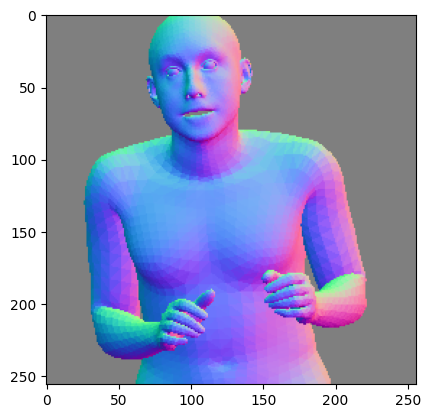

In [6]:
def normalize_depth_01(x):
    x_flat = x.view(x.size(0), -1)
    x_valid = x_flat[x_flat >= 0.0]
    if x_valid.size(0) == 0:
        print('invalid depth')
        return x
    x_valid_min = x_valid.min()
    x_valid_max = x_valid.max()
    x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)
    x_valid = 1.0 - x_valid
    x_valid = 0.1 + (x_valid * 0.9)
    x_norm = torch.zeros_like(x_flat)
    x_norm[x_flat >= 0.0] = x_valid
    return x_norm.view(x.size(0), x.size(1), x.size(2), x.size(3))

def normal_shader(fragments, meshes):
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_normals = vertex_normals[faces]
    ones = torch.ones_like(fragments.bary_coords)
    # pixel_normals = interpolate_face_attributes(fragments.pix_to_face, fragments.bary_coords, faces_normals)
    pixel_normals = interpolate_face_attributes(fragments.pix_to_face, ones, faces_normals)  # <~~~ Use fragments.bary_coords in place of ones for smoothed normals
    normals = pixel_normals[:, :, :, 0]
    normals_magnitude = normals.norm(dim=-1, keepdim=True).repeat(1, 1, 1, 3)
    normals = (normals / normals_magnitude)
    normals[normals_magnitude == 0] = 0
    return normals

rasterizer = MeshRasterizer(cameras=camera[0], raster_settings=raster_settings)
fragments = rasterizer(meshes_world=meshes[0])
depth = fragments.zbuf
print(depth.shape, depth.max())
depth = normalize_depth_01(depth)
print(depth.shape, depth.max())
plt.imshow(depth[0].detach().cpu().numpy(), cmap='gray')
plt.show()

normals = normal_shader(fragments, meshes[0])
print(normals.shape, normals.max(), normals.min())
plt.imshow((normals[0].detach().cpu().numpy()+1.)/2)

In [5]:
files = glob.glob('./data/mesh_rot_180/seth/*.obj')
files.sort()
meshes = []
for i in tqdm(range(len(files))):
    verts1, faces1, _ = load_obj(files[i], device=device)
    V = verts1.shape[0]
    verts_rgb = torch.from_numpy(np.array([0.5, 0.5, 0.5])).float()[None, None, :].repeat(1,V,1)
    textures = TexturesVertex(verts_features=verts_rgb,).to(device)
    mesh = Meshes(verts=verts1[None], faces=faces1.verts_idx[None], textures=textures,).to(device)
    meshes.append(mesh)
print(len(meshes))
save_path = './data/seth-SHOW1/'
torch.save(meshes, os.path.join(save_path, 'meshes_train.pt'))

100%|██████████| 10560/10560 [20:16<00:00,  8.68it/s]


10560


100%|██████████| 1/1 [00:00<00:00, 71.55it/s]

1


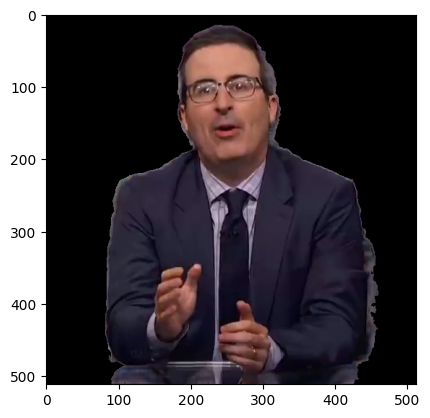

In [6]:
files = glob.glob('./data/john-oliver-SHOW1/JO_SHOW1/matted/*')
files.sort()
target_rgb = []
for i in tqdm(range(1)):
    img = Image.open(files[i])
    img = img.resize((res, res))
    img = torch.from_numpy(np.array(img)/255.)
    target_rgb.append(img[:,:,:3].to('cuda'))
print(len(target_rgb))
plt.imshow(target_rgb[0].detach().cpu())

torch.Size([512, 512, 3]) tensor(0.2500, device='cuda:0') tensor(1., device='cuda:0')


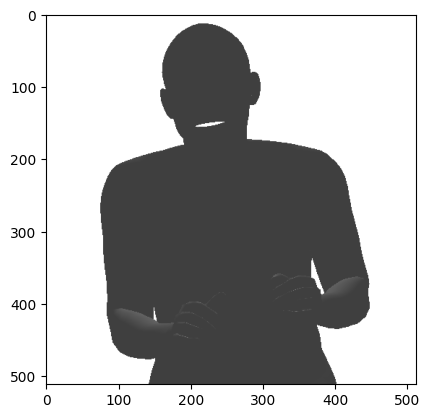

In [43]:
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=11, 
)

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings
#     ),
#     # shader=SoftSilhouetteShader()
#     shader=SoftPhongShader(
#         device=device, 
#         cameras=camera,
#         # lights=lights,
#         blend_params=blend,
#     )
# )
blend = BlendParams(background_color=(1.0, 1.0, 1.0))
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        # lights=lights,
        blend_params=blend,
    )
)

silhouette_image = renderer_silhouette(meshes[0], cameras=camera[0])

num_views = 1
silhouette_image = [silhouette_image[i, ..., :3] for i in range(num_views)]
print(silhouette_image[0].shape, silhouette_image[0].min(), silhouette_image[0].max())
plt.imshow(silhouette_image[0].detach().cpu().numpy())

In [8]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=None, 
                         target_image=None, title='', 
                         silhouette=False, camera=None,):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [9]:
# src_mesh = ico_sphere(4, device)
src_mesh = meshes[0].clone()

In [16]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
# raster_settings_soft = RasterizationSettings(
#     image_size=res, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
# )
raster_settings_soft = RasterizationSettings(
        image_size=res,
        faces_per_pixel=1,
        # blur_radius=(np.log(1. / 1e-4 - 1.)*sigma),
        cull_backfaces=True,
        perspective_correct=True
)


# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader(
    )
)

In [14]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=res, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False, 
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        materials=materials,
        blend_params=blend,
    )
)

In [55]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 1
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 100

%matplotlib inline

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([sphere_verts_rgb, deform_verts], lr=10.0, momentum=0.9)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


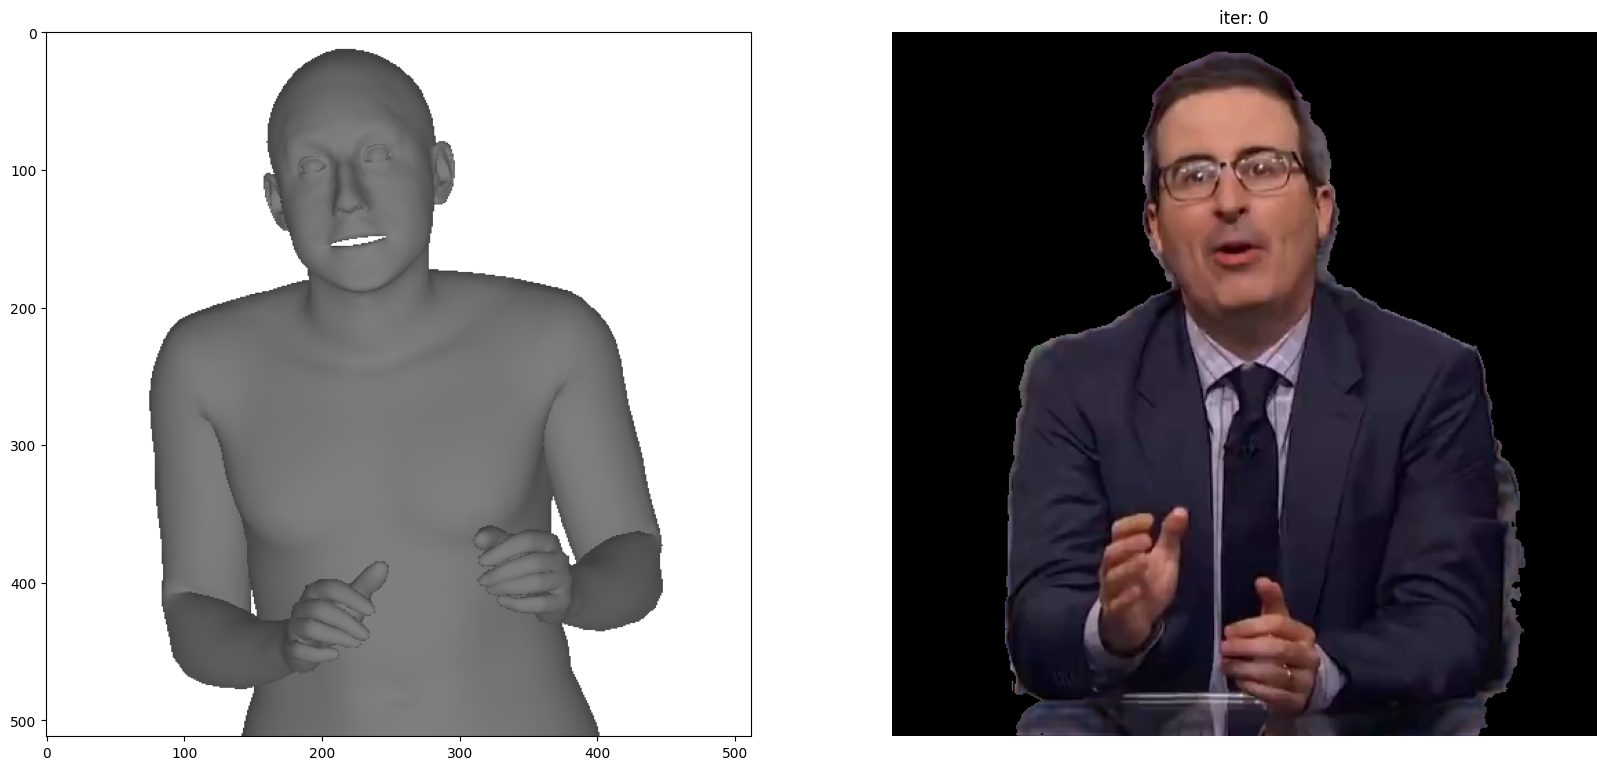

 10%|█         | 100/1000 [00:05<00:25, 34.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


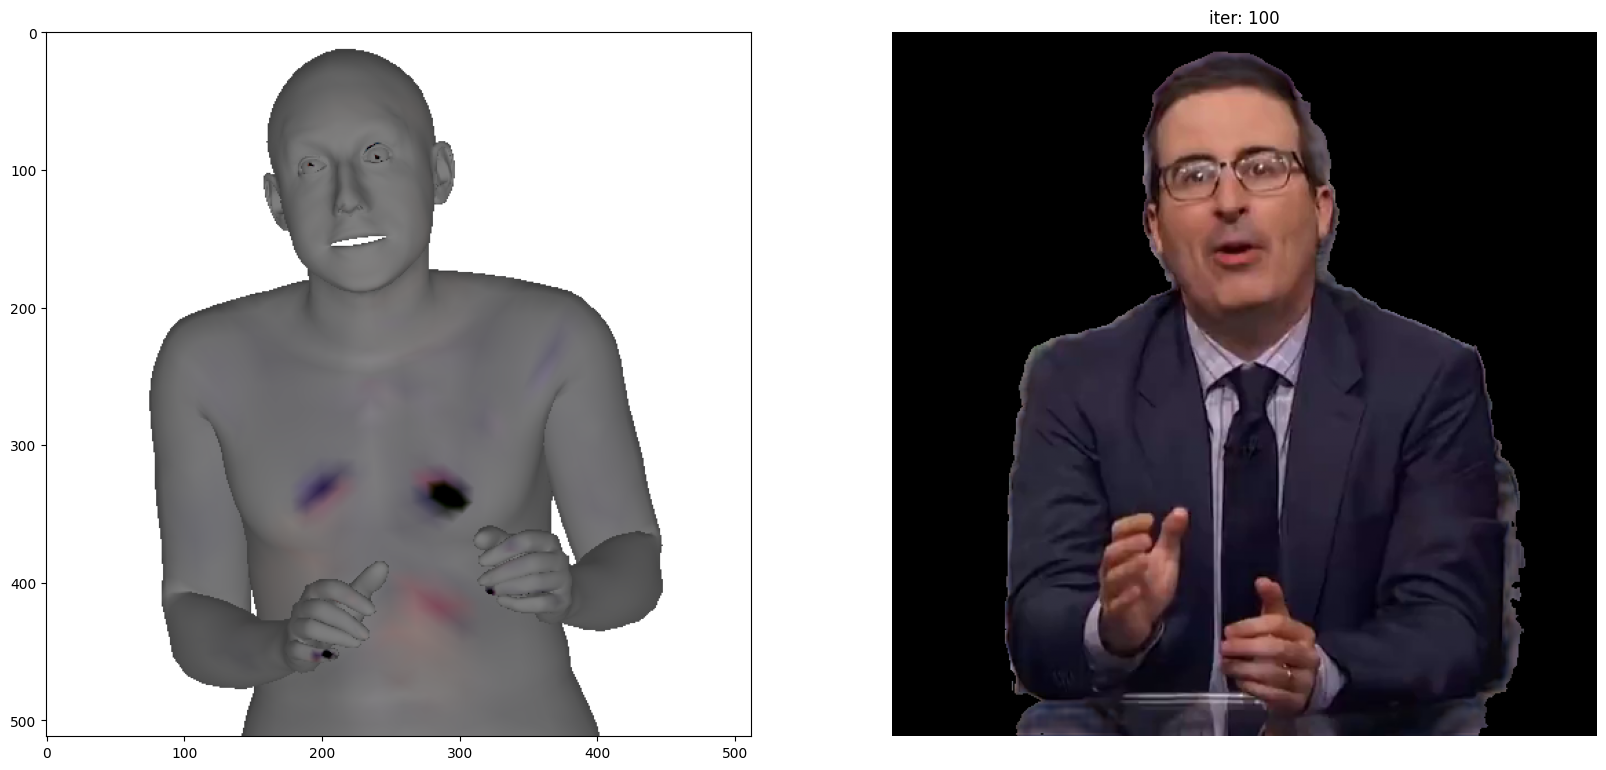

 20%|█▉        | 199/1000 [00:08<00:23, 34.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


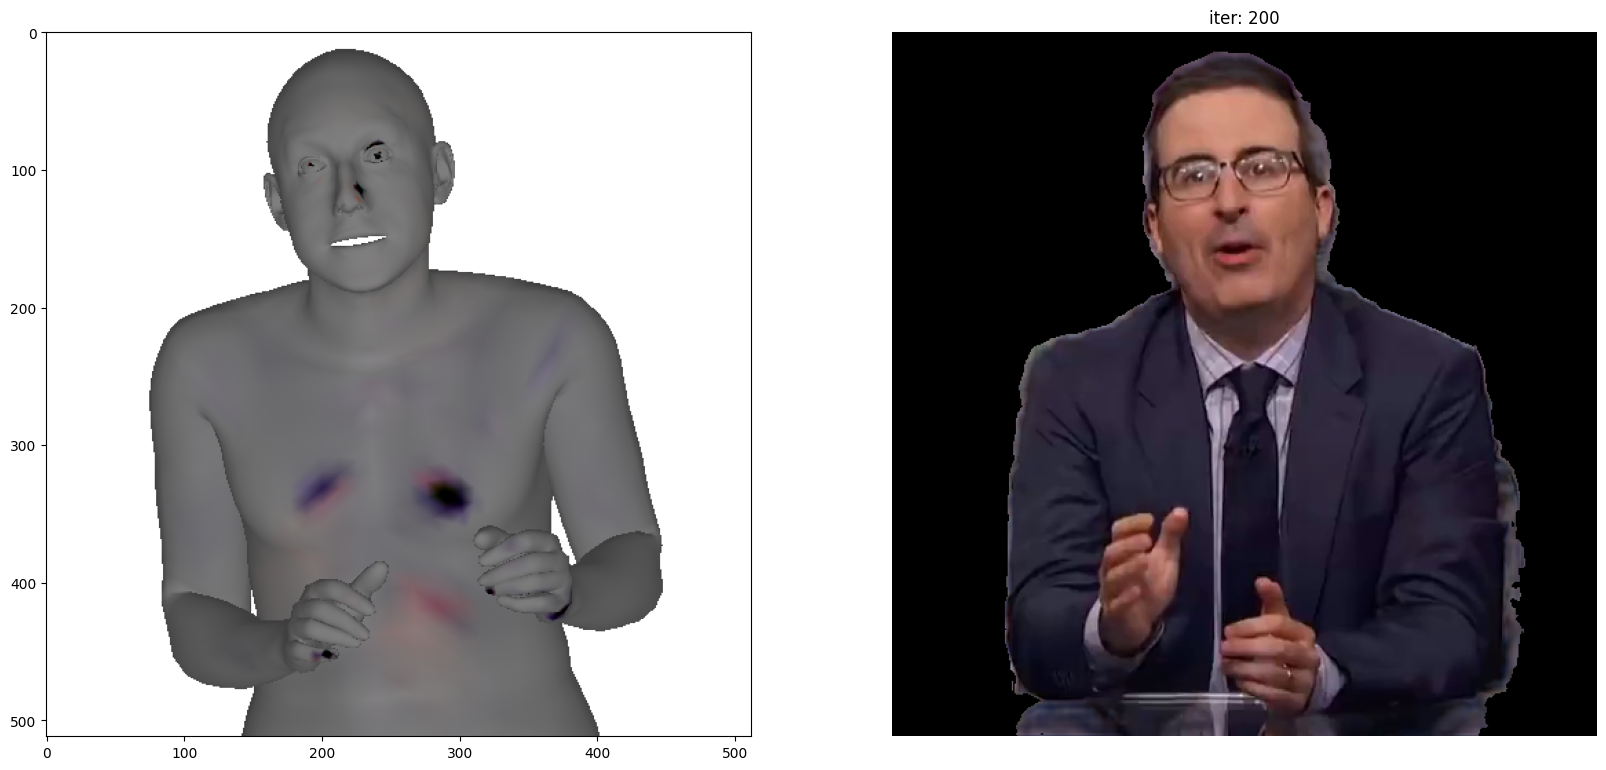

 30%|██▉       | 299/1000 [00:12<00:20, 34.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


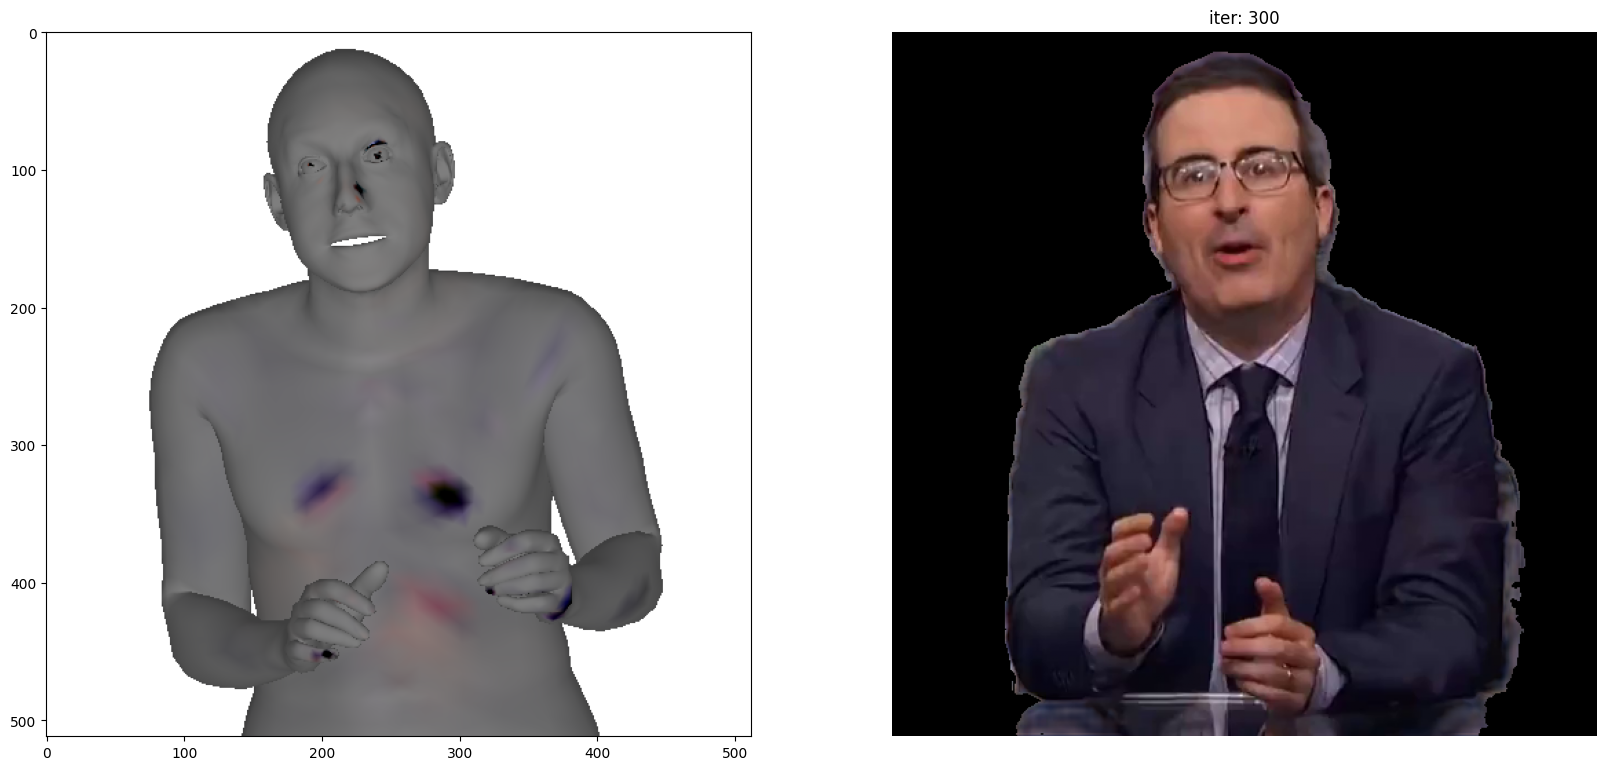

 40%|███▉      | 396/1000 [00:15<00:15, 38.66it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


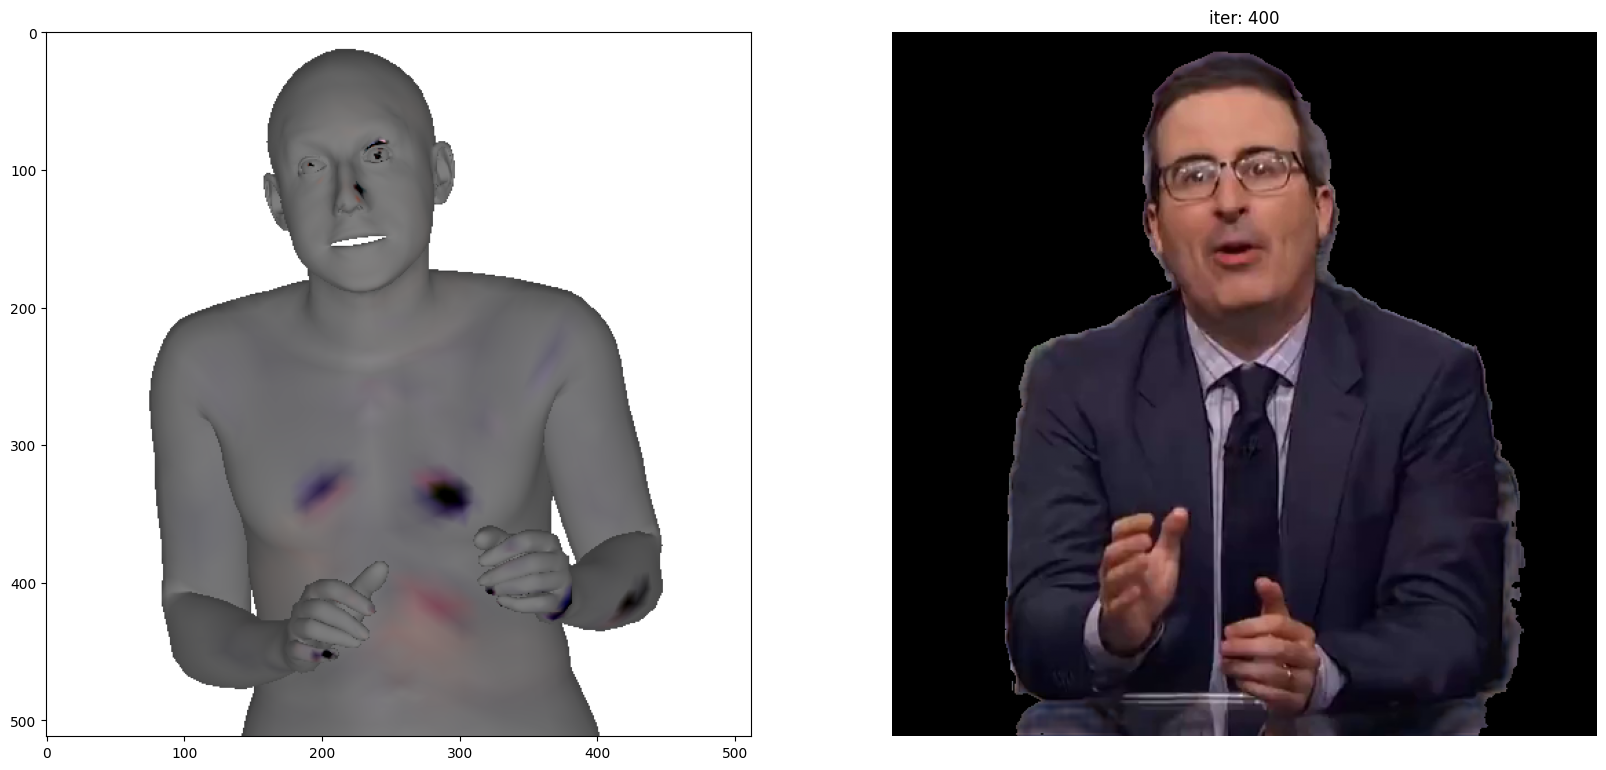

 50%|████▉     | 497/1000 [00:18<00:14, 35.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


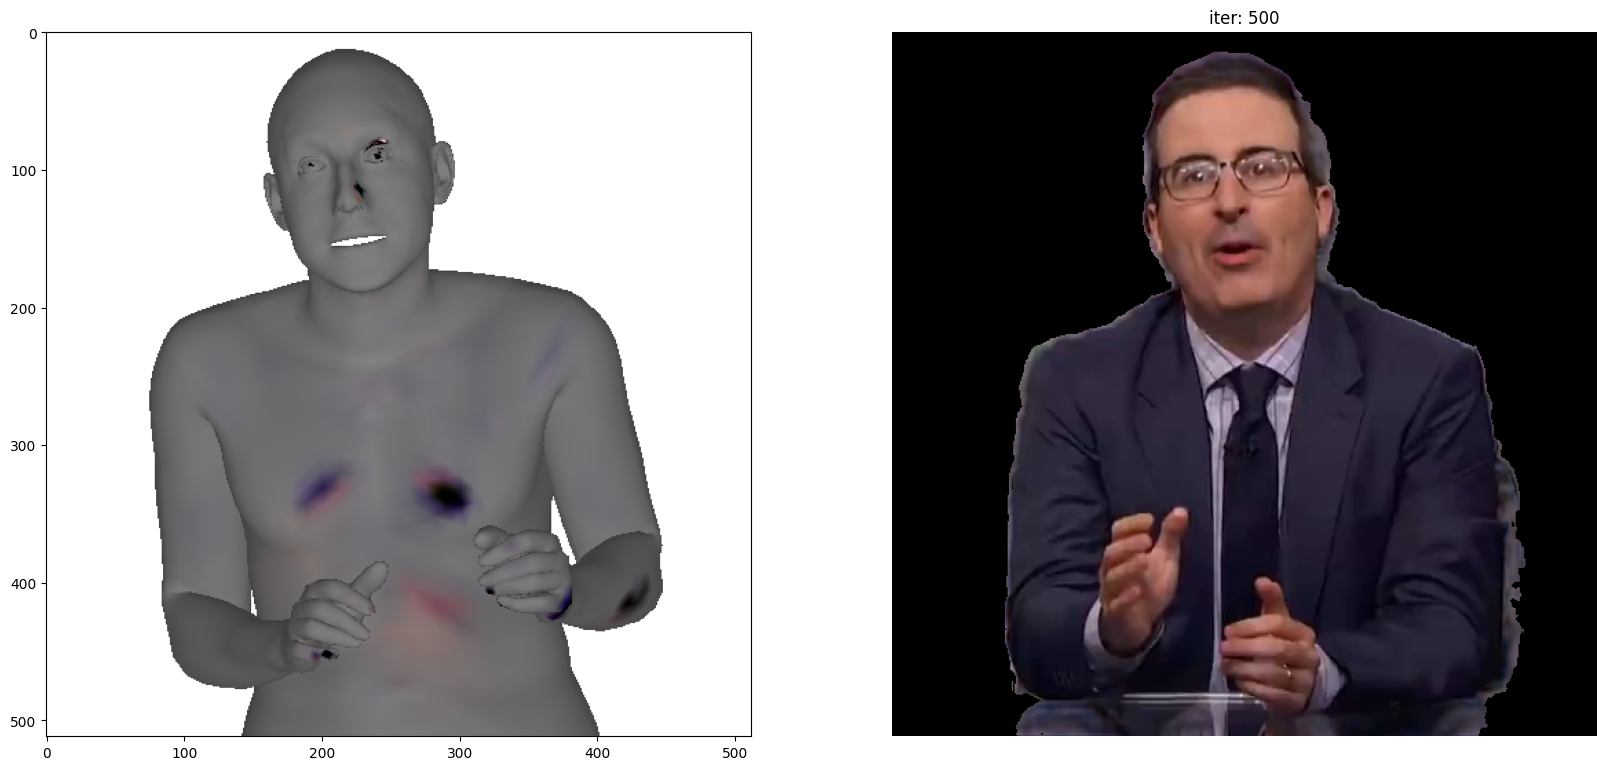

 60%|█████▉    | 598/1000 [00:21<00:11, 34.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


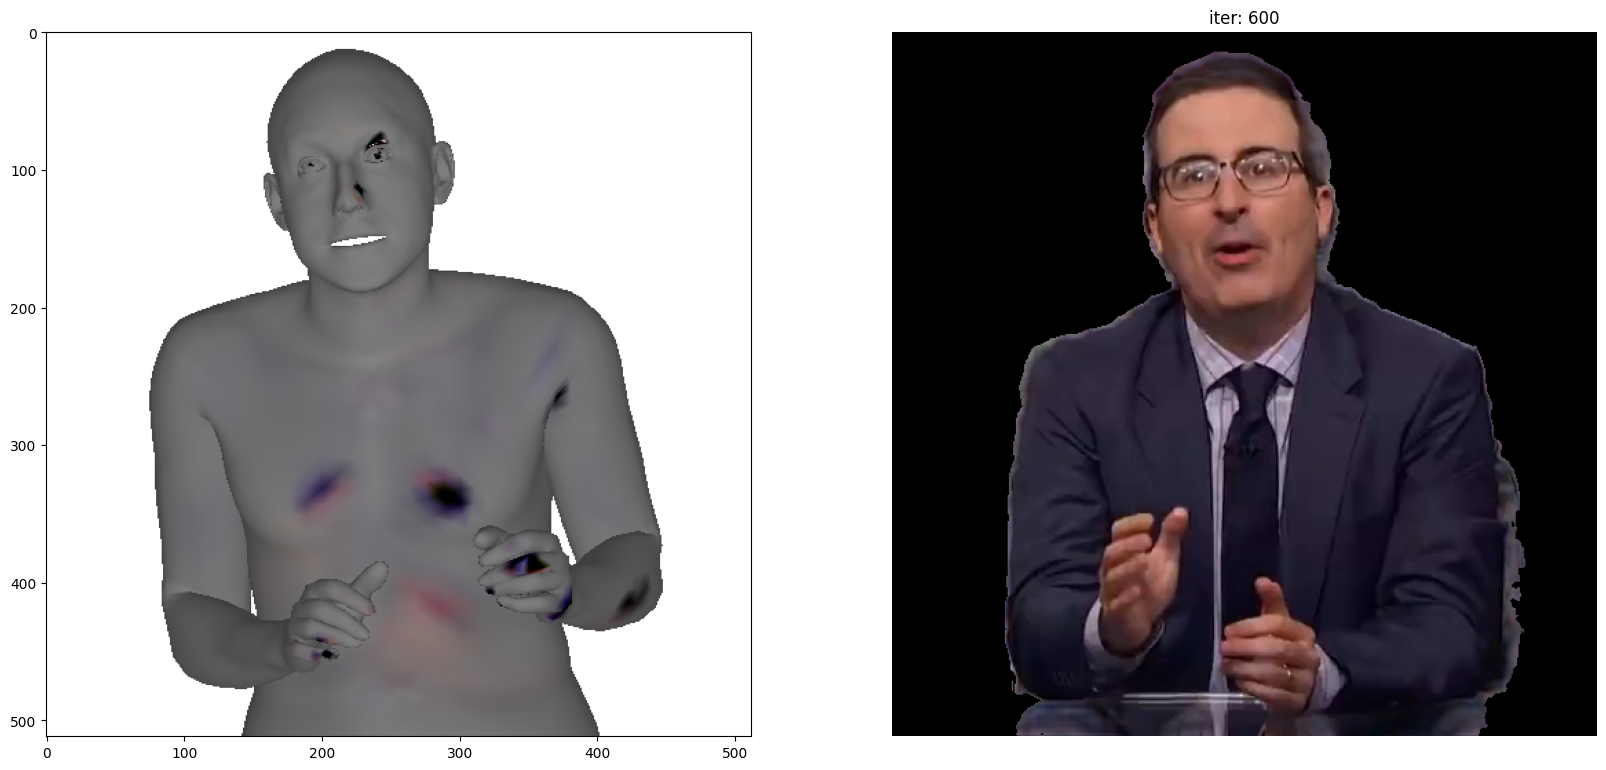

 70%|███████   | 700/1000 [00:25<00:08, 36.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


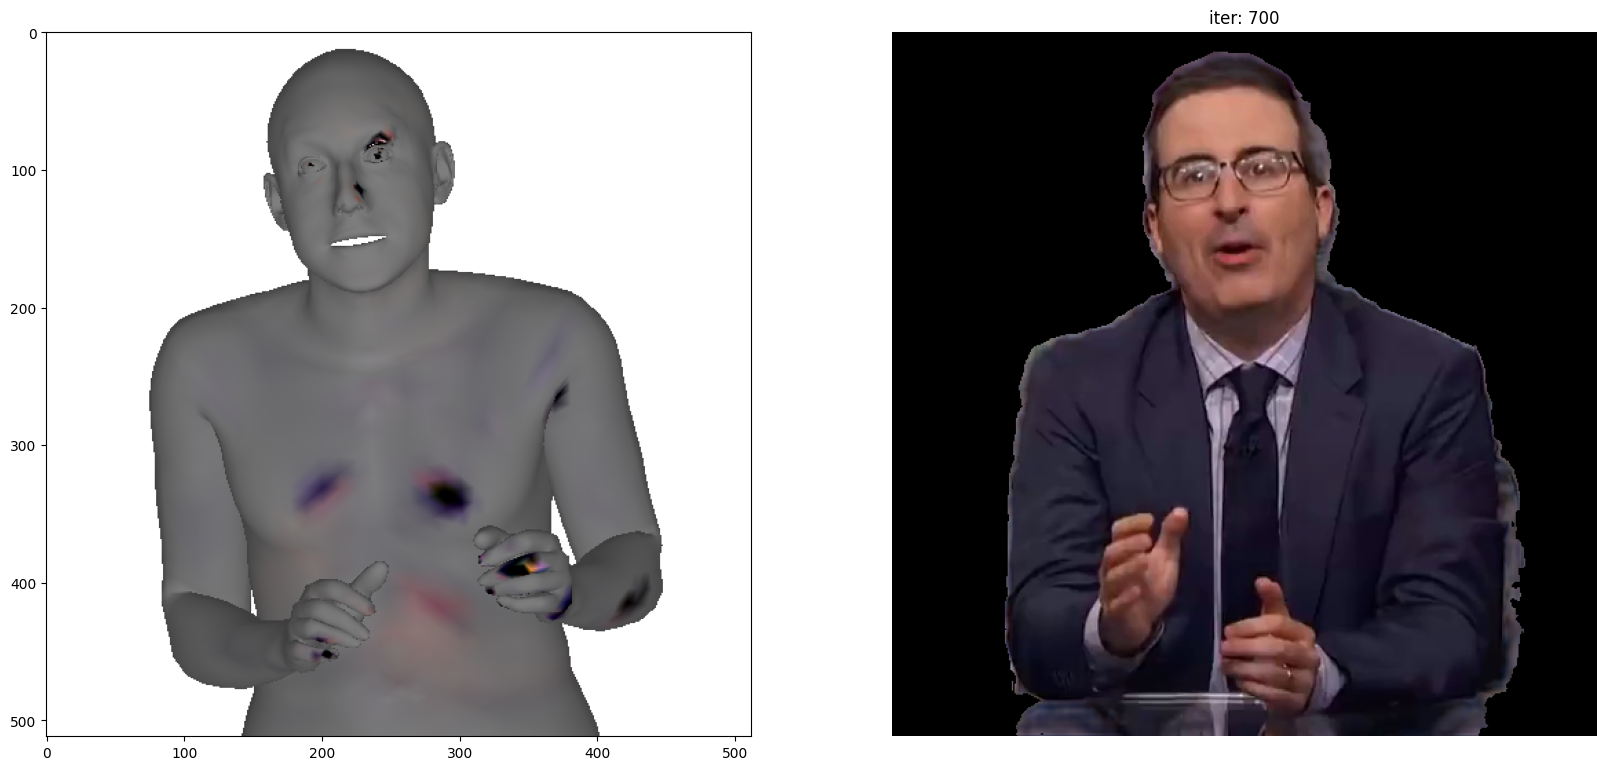

 80%|████████  | 800/1000 [00:28<00:05, 36.98it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


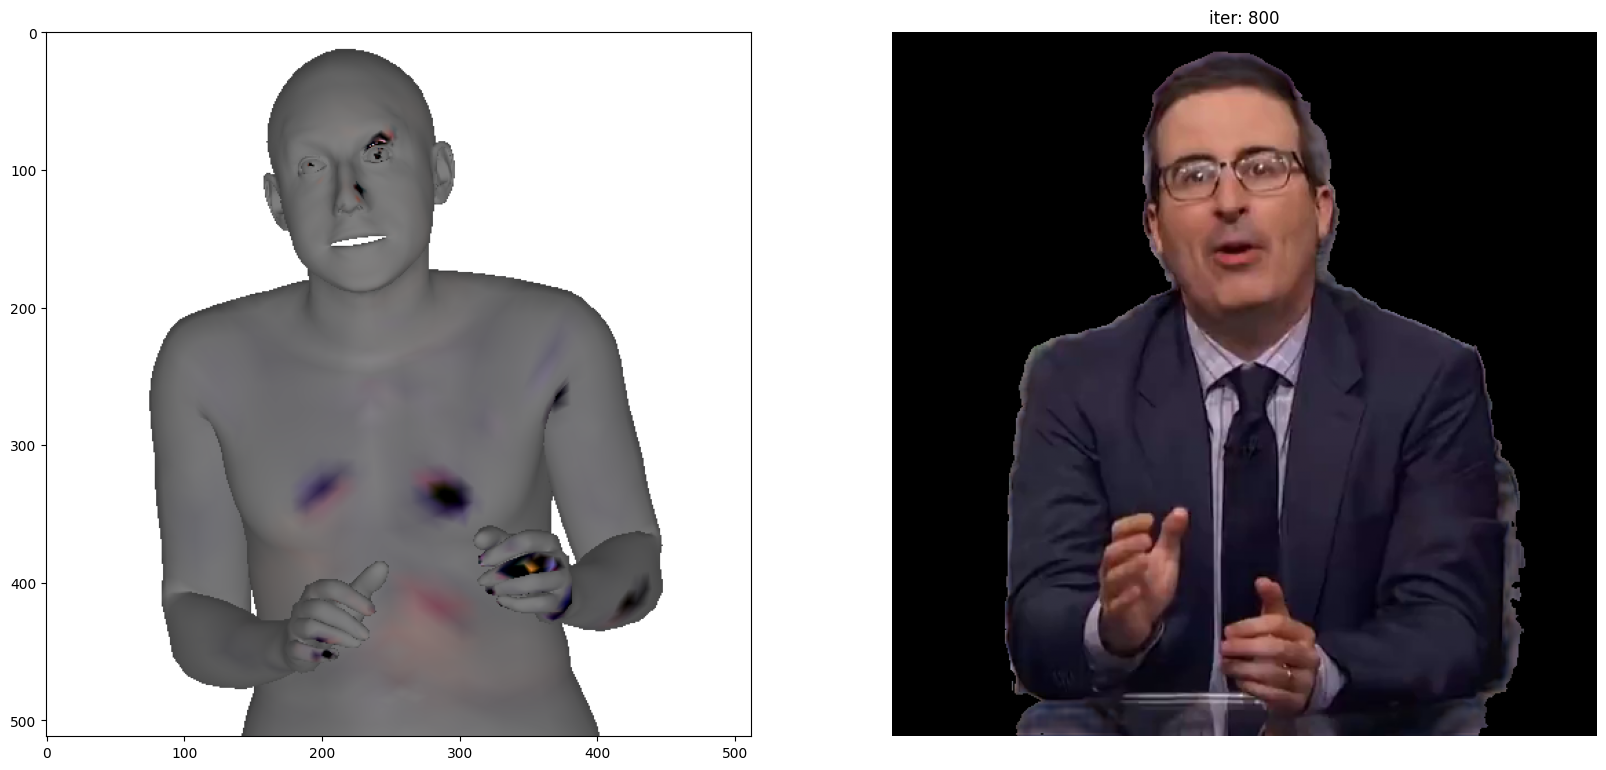

 90%|█████████ | 900/1000 [00:32<00:02, 36.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512, 4]) torch.Size([512, 512, 3])


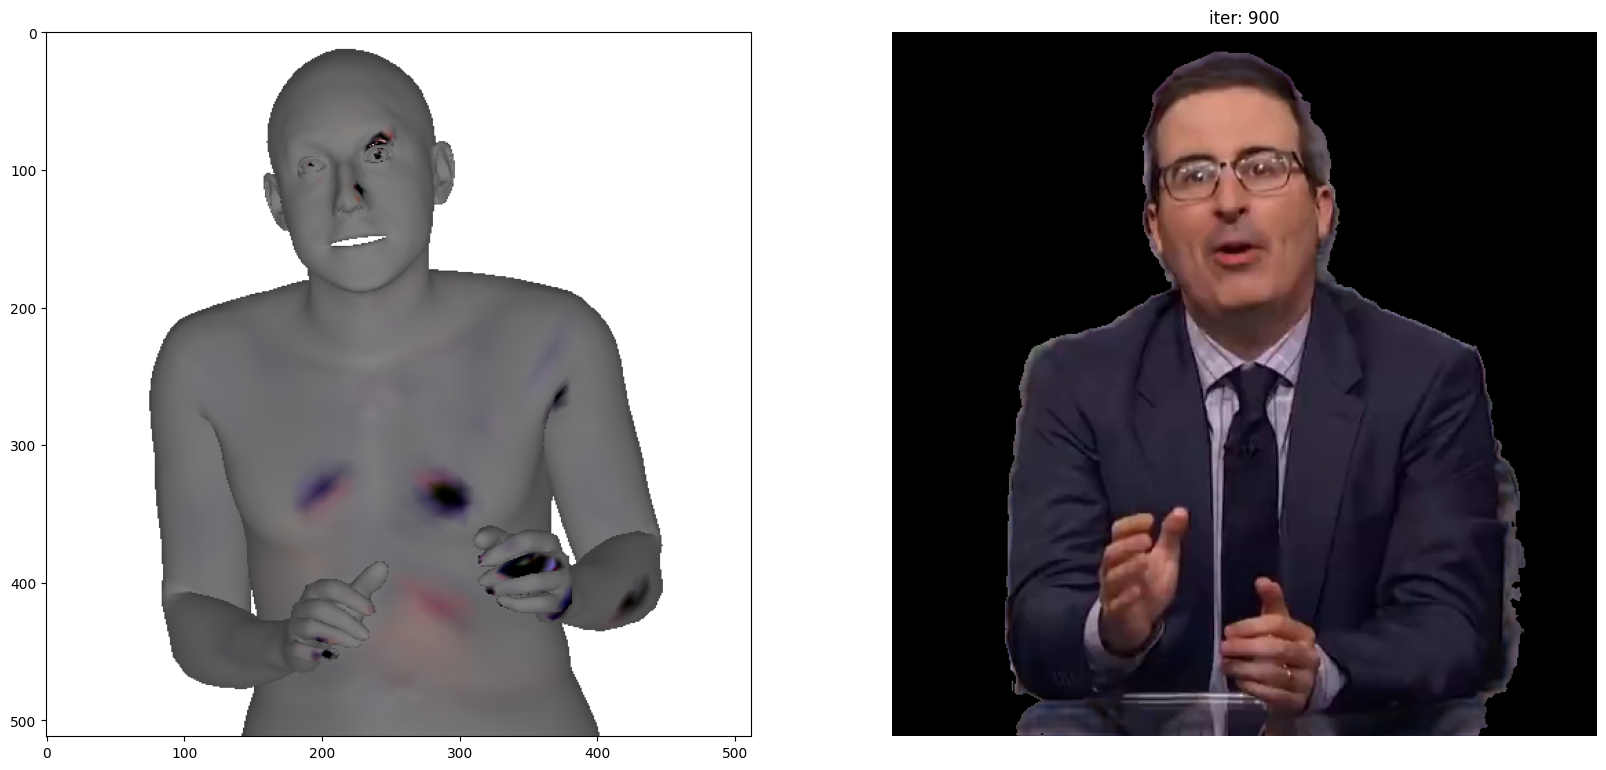

100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s]


In [58]:
loop = tqdm(range(Niter))
save_path = './checkpoints/jhon-oliver-upper-hands-vertex-texture-fitting'
os.makedirs(save_path, exist_ok=True)
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Losses to smooth /regularize the mesh shape
    
    
    
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    # update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    for j in np.random.permutation(1).tolist()[:num_views_per_iteration]:
        # print(j)
        new_src_mesh = meshes[j].clone()
        new_src_mesh = new_src_mesh.offset_verts(deform_verts)
        new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb) 
        images_predicted = renderer_textured(new_src_mesh, cameras=camera[j])

        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
    
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))
    
    # Print the losses
    # loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        # print('Plotting!')
        with torch.no_grad():
            idx = np.random.permutation(1).tolist()[0]
            new_src_mesh = meshes[idx].clone()
            new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)
            # visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
            ## visualize
            predicted_image = renderer_textured(new_src_mesh, cameras=camera[idx])
            print(predicted_image.shape, target_rgb[idx].shape)
            visualize_prediction(new_src_mesh, renderer=renderer_textured, target_image=target_rgb[idx], title="iter: %d" % i, silhouette=False, camera=camera[idx])
            # gen_viz = (predicted_image[0].detach().cpu().numpy() *255.).astype(np.uint8)
            # Image.fromarray(gen_viz).save(os.path.join(save_path, f'gen_image_{i}.jpg'))
            # target_viz = (target_rgb[idx].detach().cpu().numpy() *255.).astype(np.uint8)
            # Image.fromarray(target_viz).save(os.path.join(save_path, f'real_image_{i}.jpg'))
            # torch.save(sphere_verts_rgb.detach().cpu(), './data/jhon_oliver/checkpoints/verts_rgb.pt')
    # Optimization step
    sum_loss.backward()
    optimizer.step()


{'weight': 1.0, 'values': [0.5137178897857666, 0.5134019255638123, 0.5128085613250732, 0.5119773149490356, 0.5109483599662781, 0.5097604393959045, 0.5084506273269653, 0.5070526599884033, 0.5055983066558838, 0.5041146874427795, 0.5026265382766724, 0.5011541843414307, 0.4997152090072632, 0.4983235001564026, 0.4969901740550995, 0.4957234561443329, 0.49452877044677734, 0.49341022968292236, 0.49236905574798584, 0.4914056360721588, 0.4905183017253876, 0.48970499634742737, 0.48896265029907227, 0.4882871210575104, 0.487674355506897, 0.4871199429035187, 0.486619234085083, 0.48616740107536316, 0.4857601523399353, 0.48539310693740845, 0.48506197333335876, 0.4847628176212311, 0.4844924211502075, 0.48424702882766724, 0.4840237498283386, 0.48382002115249634, 0.48363322019577026, 0.48346149921417236, 0.483302503824234, 0.48315513134002686, 0.4830177128314972, 0.4828890264034271, 0.48276808857917786, 0.4826540946960449, 0.4825460612773895, 0.4824436902999878, 0.4823461174964905, 0.48225316405296326, 0

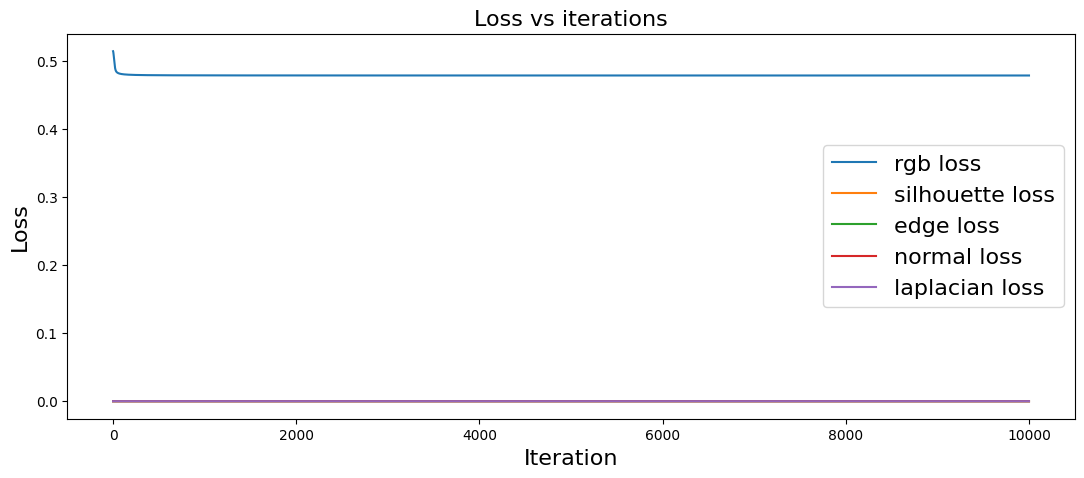

In [ ]:
plot_losses(losses)
print(losses['rgb'])

In [ ]:
sphere_verts_rgb.grad.max()

tensor(0.0003, device='cuda:0')

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

In [ ]:
for k in range(0, 1):
    new_src_mesh = meshes_all[k].clone()
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)
    visualize_prediction(new_src_mesh, renderer=renderer_textured, target_image=rgb_all[k], title="iter: %d" % k, silhouette=False)

NameError: name 'visualize_prediction' is not defined

## Infernece

In [19]:
def set_pytorch3D(T):
    n_frame = T.shape[0]
    T = T
    fl = np.array([[15.625]]).repeat(n_frame, 0)
    pp = np.array([[0.5625, 0]]).repeat(n_frame, 0)
    R = np.array([[[-1,0,0],[0,1,0],[0,0,-1]]]).repeat(n_frame, 0)
    return fl, pp, R, T

device = 'cuda'
Tr = np.load('./data/john-oliver-SHOW1/all_transl_SHOW1.npy',)
# Tr = Tr[int(Tr.shape[0]*0.8):]
print(Tr.shape)
fl, pp, R, T = set_pytorch3D(Tr)

res = 256
sigma = 1e-4
raster_settings = RasterizationSettings(
        image_size=res,
        faces_per_pixel=1,
        # blur_radius=(np.log(1. / 1e-4 - 1.)*sigma),
        cull_backfaces=True,
        perspective_correct=True
)
lights = PointLights(
            device=device,
            location=((0.0, 0.0, 5.0),),
            ambient_color=((0.5, 0.5, 0.5),),
            diffuse_color=((0.5, 0.5, 0.5),)
        )

materials = Materials(
        specular_color=((0, 0, 0),),
        device=device,
)
camera = PerspectiveCameras(focal_length=fl, 
                             principal_point=pp, 
                             R=R, 
                             T=T, 
                             image_size=res, 
                             device=device)

blend = BlendParams(background_color=(1.0, 1.0, 1.0))
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        materials=materials,
        blend_params=blend,
    )
)

(30330, 3)


In [21]:
device = 'cuda'
# files_meshes = glob.glob('./data/john-oliver-SHOW1/jo1_fullbody_rot180/*.obj')
files_meshes = glob.glob('./data/talkshow/oliver/214036-00_02_35-00_02_45/mesh/*.obj')
files_meshes.sort()
files_meshes = sorted(
            files_meshes, key=lambda x: int(x.split("/")[-1].split(".")[0])
        )
# files = files[int(len(files)*0.8):]
# meshes_test = []
# for i in tqdm(range(len(files))):
#     verts1, faces1, _ = load_obj(files[i], device=device)
#     V = verts1.shape[0]
#     verts_rgb = torch.from_numpy(np.array([0.5, 0.5, 0.5])).float()[None, None, :].repeat(1,V,1)
#     textures = TexturesVertex(verts_features=verts_rgb,).to(device)
#     mesh = Meshes(verts=verts1[None], faces=faces1.verts_idx[None], textures=textures,).to(device)
#     meshes_test.append(mesh)

In [10]:
files_rgbs = glob.glob('./data/john-oliver-SHOW1/JO_SHOW1/matted/*.png')
files_rgbs.sort()

# files = files[int(len(files)*0.8):]
# rgb_all_test = []
# for i in tqdm(range(len(files))):
#     img = Image.open(files[i])
#     img = img.resize((256, 256))
#     img = torch.from_numpy(np.array(img)/255.)
#     rgb_all_test.append(img[:,:,:3].to('cuda'))
# print(len(rgb_all_test))

In [20]:
# path = './checkpoints/jhon-oliver-upper-hands-vertex-texture-fitting-2-nogloss'
# sphere_verts_rgb = torch.load(os.path.join(path, 'verts_rgb.pt')).to('cuda')

path = './checkpoints/show-jhon-oliver-upper-hands-uv-texture-fitting-nogloss-256'
verts, faces, aux = load_obj('./data/smplx_uv.obj')
verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
texture_image = torch.load(os.path.join(path, 'texture_uv.pt')).to(device)

In [22]:
save_folder = './data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes'
print(save_folder)
os.makedirs(save_folder, exist_ok=True)
cnt = 0
outVid = []
for i in tqdm(range(len(files_meshes))):
    # read meshes
    verts1, faces1, _ = load_obj(files_meshes[i], device=device)
    mesh = Meshes(verts=verts1[None], faces=faces1.verts_idx[None],).to(device)
    new_src_mesh = mesh.clone()
    new_src_mesh.textures = TexturesUV(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image).to(device)
    with torch.no_grad():
        predicted_image = renderer_textured(new_src_mesh, cameras=camera[0])[0][...,:3].detach().cpu()
        # img = Image.open(files_rgbs[i])
        # img = img.resize((res, res))
        # img = torch.from_numpy(np.array(img)/255.)[:,:,:3]
        # com_image = torch.cat([predicted_image, gt_image], 1) * 255
        # com_image = gt_image * 255.
        # outVid.append(com_image.numpy())
        img = Image.fromarray((predicted_image.numpy() * 255).astype(np.uint8)).resize((512,512))
        outVid.append(np.array(img))
        img.save(os.path.join(save_folder, '%05d.png'%i))
        cnt += 1

    
# k = 400
# new_src_mesh = meshes_all[k].clone()
# new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)
# visualize_prediction(new_src_mesh, renderer=renderer_textured, target_image=rgb_all[k], title="iter: %d" % k, silhouette=False)

./data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes


100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


In [25]:
import cv2
path = './data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes.mp4'
moviepy.editor.ImageSequenceClip(sequence=[cv2.resize(npyFrame, (512,512)).clip(0.0, 255.0).round().astype(np.uint8) 
                                        for npyFrame in outVid], fps=30).write_videofile(os.path.join(path))

Moviepy - Building video ./data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes.mp4.
Moviepy - Writing video ./data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes.mp4



Moviepy - Done !
Moviepy - video ready ./data/john-oliver-SHOW1/JO_SHOW1/talkshow/texture_meshes.mp4
